In [1]:
using Pkg
Pkg.activate(".")
using qsrfe

  Activating project at `c:\Users\grsbe\Desktop\Masterthesis\qsrfe`


In [1]:
include("src/qsrfe.jl")
using .qsrfe
using Plots

In [2]:
#2^8 = 256, 2^9 = 512, 2^10 = 1024, 2^11 = 2048, 2^12 = 4096, 2^13 = 8192, 2^14 = 16384
N = 2^8
λ = 0.003
MSQ2 = MSQ(K=2)
MSQ4 = MSQ(K=16)
MSQ8 = MSQ(K=256)

λ_c = 16
p = N ÷ λ_c
model2 = srfeRegressor(N= p*λ_c,λ=λ, σ2=1.0)

ΣΔ1Q2 = ΣΔQ(K=2,r=1,λ=λ_c,condense=true)
ΣΔ1Q4 = ΣΔQ(K=16,r=1,λ=λ_c,condense=true)
ΣΔ1Q8 = ΣΔQ(K=256,r=1,λ=λ_c,condense=true)

βQ2 = βQ(K=2,β=1.5,λ=λ_c,condense=true)
βQ4 = βQ(K=16,β=1.5,λ=λ_c,condense=true)
βQ8 = βQ(K=256,β=1.5,λ=λ_c,condense=true);

In [3]:
#boston dataset
using LinearAlgebra
using MLJ, MLJLinearModels
X, Y = @load_boston
(xtrain, xtest), (ytrain, ytest) = load_dataset(X,Y;normalize=true,partitioning=0.8,rng=1234);
indexmaptrain = ytrain .<= 47
indexmaptest = ytest .<= 47
(xtrain, xtest), (ytrain, ytest) = (xtrain[indexmaptrain,:], xtest[indexmaptest,:]), (ytrain[indexmaptrain], ytest[indexmaptest])

(([0.0005258688489131264 0.0428728179250255 … 0.04792704786097089 0.02059703773458206; 0.08821644274022668 0.0 … 0.04792704786097089 0.11620646698099267; … ; 0.00013014383682632827 0.0 … 0.04743558128300629 0.012333738792030565; 0.0006105171854344649 0.0 … 0.04772659711909835 0.03755210297226179], [0.0015519497551627708 0.0 … 0.04792704786097089 0.04710080397254352; 0.001380840892380482 0.0 … 0.04213450443469029 0.09043721620459136; … ; 0.007135830924146997 0.0 … 0.04124938158051816 0.040643188872994014; 0.0024826045648607543 0.0 … 0.046906681132764284 0.029196989597015277]), ([22.2, 13.8, 22.0, 14.6, 27.5, 25.3, 12.7, 14.4, 12.7, 25.0  …  13.4, 23.3, 22.8, 33.4, 23.5, 10.4, 20.6, 20.5, 34.7, 19.8], [18.0, 23.7, 8.1, 29.6, 44.0, 33.1, 8.3, 21.4, 22.6, 29.0  …  23.4, 20.3, 10.5, 22.9, 16.7, 19.9, 15.7, 21.4, 19.6, 25.1]))

In [ ]:
#other datasets here

In [4]:
#test cell for hyperparameter testing
#model = model
N= 2^7
λ = 0.003
model = srfeRegressor(N=N,λ=λ, σ2=10.0)

c, ω, ζ = qsrfe.fit(model,xtrain,ytrain;max_iter=2000000,verbose=true)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
ytestpred = qsrfe.predict(model,xtest,c, ω, ζ);

println("")
println("rel: ",rel_error(ytest,ytestpred)," train rel: ",rel_error(ytrain,ytrainpred))
println("abs: ",abs_error(ytest,ytestpred)," train abs: ",abs_error(ytrain,ytrainpred))
println("mse: ",mse(ytest,ytestpred)," train mse: ",mse(ytrain,ytrainpred))

support: 71/128


rel: 0.10835269766984301 train rel: 0.09055411827185356
abs: 2.1695907675749018 train abs: 

1.6980375432277044
mse: 9.288800027650671 train mse: 4.897298703903295


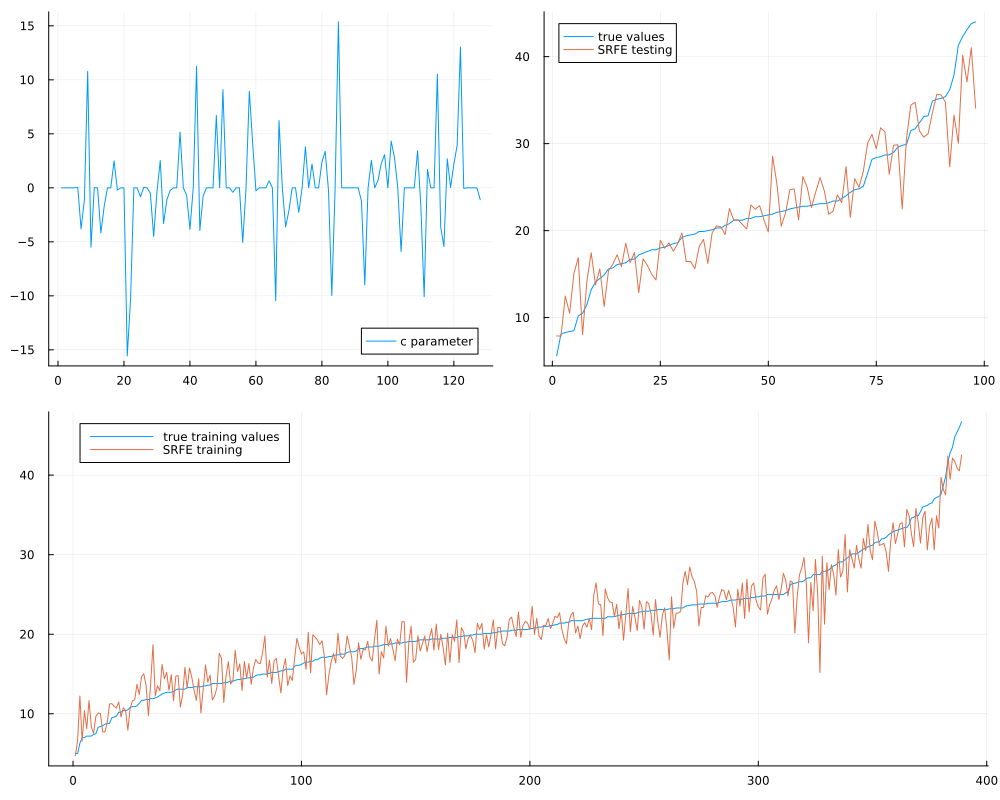

In [5]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [6]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128

: avg. test error: 0.10721052984360054 avg. train error: 0.09144475901796002
abs. test error:2.1695044281239215 abs. train error: 1.6822767936282013
mse. test error:9.490232448682166 mse train error: 4.7997029939351155
rel mse test error:0.012812818512026262 rel mse train error: 0.004962740328255848
current iter: 256

: avg. test error: 0.10535615914517579 avg. train error: 0.08387193276289029
abs. test error:2.129118039695242 abs. train error: 1.5403811599285755
mse. test error:8.835892551930595 mse train error: 4.1879098768406955
rel mse test error:0.012366453343942468 rel mse train error: 0.00463584161946854
current iter: 512: 

avg. test error: 0.09847837467973494 avg. train error: 0.07746699299005884
abs. test error:1.9999980848754735 abs. train error: 1.420443441040084
mse. test error:7.954443907867878 mse train error: 3.6118765845719656
rel mse test error:0.011736275006711367 rel mse train error: 0.004305547350467975
current iter: 1024: 

avg. test error: 0.10030634787690862 avg. train error: 0.0738640916730227
abs. test error:2.0033209094102844 abs. train error: 1.3553362770764288
mse. test error:7.816227849625861 mse train error: 3.2843880988927503
rel mse test error:0.011631466477257785 rel mse train error: 0.004105716898627007
current iter: 2048

: avg. test error: 0.09893716144366921 avg. train error: 0.07123870345788079
abs. test error:1.969214867773961 abs. train error: 1.307904327357586
mse. test error:7.619169763636135 mse train error: 3.0864445765942463
rel mse test error:0.011487054558629204 rel mse train error: 0.003979873412503146
current iter: 4096: 

avg. test error: 0.09782371246330054 avg. train error: 0.06784025512881713
abs. test error:1.9563474848660989 abs. train error: 1.2444220579828875
mse. test error:7.450707408087605 mse train error: 2.856799339468455
rel mse test error:0.011358156170422042 rel mse train error: 0.0038290285054384436
current iter: 8192: avg. test error: 

0.0990875023819248 avg. train error: 0.06608359440373049
abs. test error:1.9857213197009156 abs. train error: 1.2088475642683716
mse. test error:7.80135597194617 mse train error: 2.6957059452957925
rel mse test error:0.011617745469349922 rel mse train error: 0.0037194275484876416
current iter: 16384

: avg. test error: 0.10012388729305197 avg. train error: 0.06390082940844939
abs. test error:2.0033688314907843 abs. train error: 1.1700567245092495
mse. test error:7.733718193526974 mse train error: 2.5011737852749034
rel mse test error:0.011573115076085654 rel mse train error: 0.003582908555091272


In [62]:
#test cell for hyperparameter testing quantized version
# 2^7 = 128, 2^8 = 256, 2^9 = 512, 2^10 =1024, 2^11 = 2048, 2^12 4096, 2^13 8192, 2^14 = 16384, 2^15 = 32768
N= 2^13
λ = 0.003
quant = MSQ(K=8)
quant = βQ(K=2,β=1.1,λ=4,condense=true)
model = srfeRegressor(N=N,λ=λ, σ2=10.0)

c, ω, ζ = qsrfe.fit(model,xtrain,ytrain,quant;max_iter=2000000,verbose=true)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ,quant)
ytestpred = qsrfe.predict(model,xtest,c, ω, ζ,quant);

println("")
println("rel: ",rel_error(ytest,ytestpred)," train rel: ",rel_error(ytrain,ytrainpred))
println("abs: ",abs_error(ytest,ytestpred)," train abs: ",abs_error(ytrain,ytrainpred))
println("mse: ",mse(ytest,ytestpred)," train mse: ",mse(ytrain,ytrainpred))

support: 77/2048


rel: 0.13394845586171794 train rel: 0.09992900783816004
abs: 2.819327045980693 train abs: 1.9188848617954224
mse: 15.384064121731141 train mse: 6.229251463500553


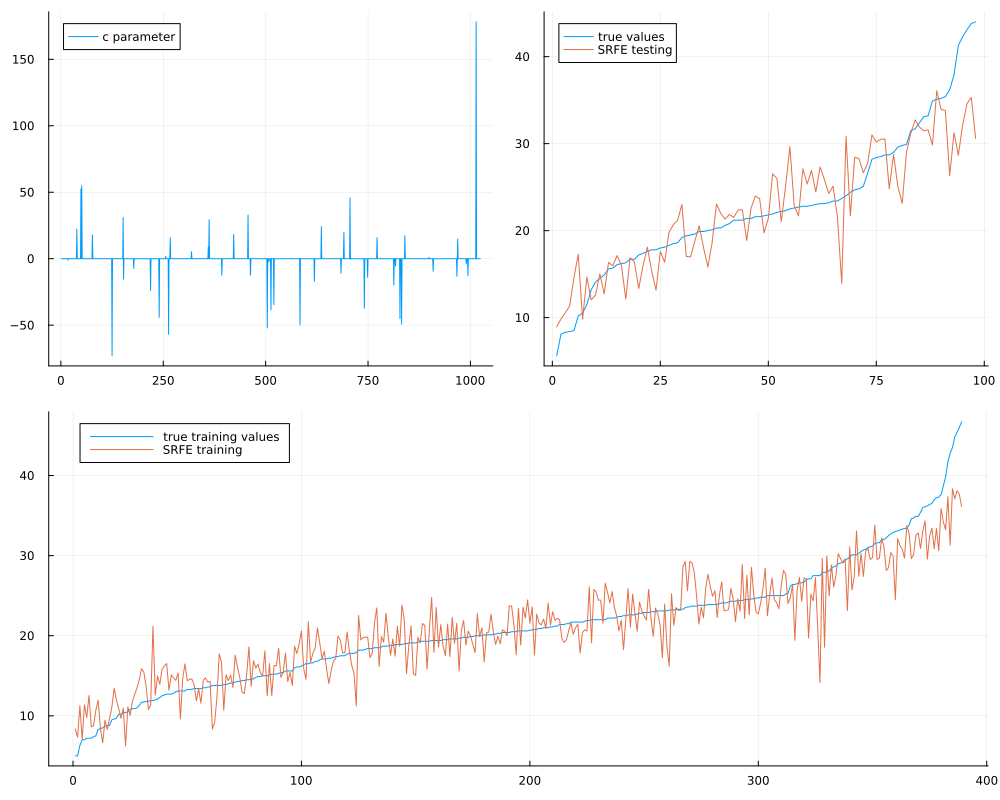

In [60]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [57]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = MSQ2
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: 

avg. test error: 0.18099258168203494 avg. train error: 0.11561615018581517
abs. test error:3.7285816445198976 abs. train error: 2.26885725821212
mse. test error:24.793618418792626 mse train error: 9.09344709525352
rel mse test error:0.020692418659477792 rel mse train error: 0.006821568688877876
current iter: 256: 

avg. test error: 0.17525568377222808 avg. train error: 0.08111693748266244
abs. test error:3.550524726766929 abs. train error: 1.575850970882557
mse. test error:22.90129855006998 mse train error: 4.280929413811765
rel mse test error:0.019854862233487723 rel mse train error: 0.004674139735617982
current iter: 512

: avg. test error: 0.2193465252058004 avg. train error: 0.03305146119887767
abs. test error:4.251378023888444 abs. train error: 0.6409110093457677
mse. test error:31.213828556801264 mse train error: 0.7426117391604821
rel mse test error:0.02324196497830347 rel mse train error: 0.0019429252842465283
current iter: 1024: 

avg. test error: 0.17024705585250982 avg. train error: 0.012677419733779024
abs. test error:3.4020576981777912 abs. train error: 0.2424395368342324
mse. test error:19.690763794129246 mse train error: 0.09920078775664656
rel mse test error:0.018446870580686364 rel mse train error: 0.0007128652879042682
current iter: 2048

: avg. test error: 0.15156432011648843 avg. train error: 0.007867026629701821
abs. test error:3.118182421741357 abs. train error: 0.14882219382122203
mse. test error:16.9725243074364 mse train error: 0.037041484939740285
rel mse test error:0.017126665808853053 rel mse train error: 0.0004357268186219532
current iter: 4096: 

avg. test error: 0.13185305369514436 avg. train error: 0.005508956158966906
abs. test error:2.795718474610546 abs. train error: 0.10359925116998929
mse. test error:15.195202862611282 mse train error: 0.018016858457824445
rel mse test error:0.016182560850019727 rel mse train error: 0.00030398852255143153
current iter: 8192: 

avg. test error: 0.13280522421995306 avg. train error: 0.004384881953190352
abs. test error:2.6816375117106293 abs. train error: 0.08180308859690133
mse. test error:13.180825472844143 mse train error: 0.011220986869743778
rel mse test error:0.015100897084896819 rel mse train error: 0.0002397925542804925
current iter: 16384: 

avg. test error: 0.12173111170593727 avg. train error: 0.0035921122851845567
abs. test error:2.5813741930779033 abs. train error: 0.06760485777368155
mse. test error:12.486710539188152 mse train error: 0.007553455622630284
rel mse test error:0.01469972395654262 rel mse train error: 0.00019686689353407553


In [58]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = ΣΔ1Q2
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128

: avg. test error: 0.2707409683872607 avg. train error: 0.30564940153241804
abs. test error:5.7927731310792705 abs. train error: 5.714019019967357
mse. test error:63.61054245900338 mse train error: 56.21478832154874
rel mse test error:0.0328650403830273 rel mse train error: 0.016769728936986698
current iter: 256

: avg. test error: 0.2157314446750896 avg. train error: 0.214524203522889
abs. test error:4.696560106943532 abs. train error: 4.202439360248516
mse. test error:39.754036945366536 mse train error: 30.758221466948562
rel mse test error:0.026234056284397476 rel mse train error: 0.012551297219231521
current iter: 512: 

avg. test error: 0.2176581024107919 avg. train error: 0.1860785191135757
abs. test error:4.555662467493389 abs. train error: 3.5991972588606815
mse. test error:38.11749305916052 mse train error: 22.77852298918981
rel mse test error:0.025661346846859567 rel mse train error: 0.010806711164615772
current iter: 1024: 

avg. test error: 0.17662416236689255 avg. train error: 0.15560735936721523
abs. test error:3.777252927085012 abs. train error: 3.0089662933777803
mse. test error:25.554041939629478 mse train error: 15.125250004627564
rel mse test error:0.02100115245798853 rel mse train error: 0.00880441294608084
current iter: 2048: 

avg. test error: 0.1702082340031575 avg. train error: 0.1286574878660546
abs. test error:3.5403845466324215 abs. train error: 2.4773300209404643
mse. test error:22.57912921671804 mse train error: 10.408313518269352
rel mse test error:0.01976366269018726 rel mse train error: 0.00730876018196844
current iter: 4096: 

avg. test error: 0.1627820934510191 avg. train error: 0.11497774756409558
abs. test error:3.409050263664791 abs. train error: 2.203771459455525
mse. test error:20.55696972276446 mse train error: 8.302693073925582
rel mse test error:0.01886837388235681 rel mse train error: 0.0065257336518189605
current iter: 8192

: avg. test error: 0.16287685864511725 avg. train error: 0.1069277188241683
abs. test error:3.4828336720125654 abs. train error: 2.0729204343058205
mse. test error:21.352517752169103 mse train error: 7.289914554757895
rel mse test error:0.019225626909829645 rel mse train error: 0.006115024790791678
current iter: 16384: 

avg. test error: 0.15151919837869568 avg. train error: 0.10594303794959466
abs. test error:3.2788295011561646 abs. train error: 2.036176739054578
mse. test error:20.38257735624262 mse train error: 7.097208955767849
rel mse test error:0.018789117819996676 rel mse train error: 0.006031472309870905


In [ ]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = ΣΔ2Q2
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

In [60]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14, 2^15]
λ = 0.003
quant = βQ2
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128

: avg. test error: 0.25666011387999654 avg. train error: 0.26455824986907306
abs. test error:5.440613790065716 abs. train error: 4.946566058605287
mse. test error:53.750903796502215 mse train error: 43.19034107341009
rel mse test error:0.030366426453632078 rel mse train error: 0.014778048045816778
current iter: 256

: avg. test error: 0.18062669493049116 avg. train error: 0.16610196056218268
abs. test error:3.7894195391538616 abs. train error: 3.205560742344345
mse. test error:26.383762071756017 mse train error: 18.07407717153784
rel mse test error:0.02136492363653652 rel mse train error: 0.009616114156546136
current iter: 512

: avg. test error: 0.15177358229110102 avg. train error: 0.1406537380634459
abs. test error:3.1585118561554144 abs. train error: 2.6772572403783137
mse. test error:18.911748698379718 mse train error: 12.7273735887406
rel mse test error:0.018076163673092272 rel mse train error: 0.008079030332812326
current iter: 1024: 

avg. test error: 0.14438349992408397 avg. train error: 0.12488602233170887
abs. test error:3.0331168173849865 abs. train error: 2.3835018610004144
mse. test error:17.14652170788218 mse train error: 9.898399290572693
rel mse test error:0.01723400462687849 rel mse train error: 0.007124610918241037
current iter: 2048

: avg. test error: 0.1266656644176515 avg. train error: 0.11464840340302733
abs. test error:2.646929478610848 abs. train error: 2.157875734047053
mse. test error:13.753336732218191 mse train error: 8.07665222855439
rel mse test error:0.01543119969551118 rel mse train error: 0.006438209659645941
current iter: 4096: 

avg. test error: 0.13257243256054344 avg. train error: 0.11520962449280947
abs. test error:2.779776244159295 abs. train error: 2.2160817928468988
mse. test error:14.554857325915432 mse train error: 8.59009692668266
rel mse test error:0.015864438986501566 rel mse train error: 0.0066388161168326396
current iter: 8192: 

avg. test error: 0.1325896683211006 avg. train error: 0.11386513902987545
abs. test error:2.768461626717347 abs. train error: 2.1872555209465294
mse. test error:14.859827919939018 mse train error: 8.315552779263612
rel mse test error:0.016034967705543614 rel mse train error: 0.00653076029871566
current iter: 16384: 

avg. test error: 0.138711309121948 avg. train error: 0.12114403039030681
abs. test error:2.9401636035963543 abs. train error: 2.3578136989523903
mse. test error:16.80392781646581 mse train error: 9.660616243020684
rel mse test error:0.0170600788283685 rel mse train error: 0.007041143987693818
current iter: 32768

: 

avg. test error: 0.14185360243100642 avg. train error: 0.1235474058011126
abs. test error:3.009401324586852 abs. train error: 2.4105028634164007
mse. test error:17.401750849876883 mse train error: 10.339287928472602
rel mse test error:0.017354611603411303 rel mse train error: 0.007283667376146621


In [61]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = βQ(K=2,β=1.2,λ=32)
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: 

avg. test error: 0.21855831072698018 avg. train error: 0.1494139788779526
abs. test error:4.416637652552266 abs. train error: 2.826188560307367
mse. test error:33.51076037856517 mse train error: 13.219527927398417
rel mse test error:0.024056230105420642 rel mse train error: 0.008218115113515976
current iter: 256

: avg. test error: 0.23776285090955324 avg. train error: 0.09821426988790348
abs. test error:4.8595210999066305 abs. train error: 1.8369097880094334
mse. test error:38.03122566753349 mse train error: 5.381251920476219
rel mse test error:0.025565999181170453 rel mse train error: 0.005248115867051987
current iter: 512

: avg. test error: 0.3065116799034918 avg. train error: 0.014567515884466014
abs. test error:5.843984975254154 abs. train error: 0.2736477801914588
mse. test error:52.53602537857438 mse train error: 0.120165103146359
rel mse test error:0.030020754255584377 rel mse train error: 0.0007770133563955202
current iter: 1024: 

avg. test error: 0.23181278769719088 avg. train error: 0.004041435721242291
abs. test error:4.765113784984708 abs. train error: 0.07683057447468734
mse. test error:37.164661472077064 mse train error: 0.009361189046363978
rel mse test error:0.0253270844759887 rel mse train error: 0.00021914967285865654
current iter: 2048: 

avg. test error: 0.19985788413447952 avg. train error: 0.0022322397050830094
abs. test error:4.229004579312219 abs. train error: 0.04296834902731288
mse. test error:31.567310574456496 mse train error: 0.0030217636852415265
rel mse test error:0.023328289227259637 rel mse train error: 0.00012450305841436046
current iter: 4096: 

avg. test error: 0.18448408909380887 avg. train error: 0.0014797085224405094
abs. test error:3.8379176219521156 abs. train error: 0.029121520620259744
mse. test error:25.794988948299 mse train error: 0.0014726793450105104
rel mse test error:0.021091326931555084 rel mse train error: 8.693588788576726e-5
current iter: 8192: 

avg. test error: 0.17817361853422287 avg. train error: 0.0011512552685867185
abs. test error:3.688154126328153 abs. train error: 0.02256576340824269
mse. test error:24.54738703265256 mse train error: 0.0009088325942226002
rel mse test error:0.020590944669323385 rel mse train error: 6.829466443454397e-5
current iter: 16384: 

avg. test error: 0.17079859800525726 avg. train error: 0.0009365078226258657
abs. test error:3.608947051180943 abs. train error: 0.018618425284984478
mse. test error:23.46246024553815 mse train error: 0.0006375614814146524
rel mse test error:0.0201560733909913 rel mse train error: 5.718064914741624e-5
